In [ ]:
! pip install scikit-surprise

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import KNNImputer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from surprise import SVD, KNNBasic, NMF, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split as surprise_train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Load datasets
product_info = pd.read_csv('/content/product_info.csv')
reviews = pd.read_csv('/content/reviews.csv', encoding='latin-1') # Changed to 'latin-1' encoding

<ipython-input-7-8d818a128974>:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv('/content/reviews.csv', encoding='latin-1') # Changed to 'latin-1' encoding


In [ ]:
print(product_info.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          8494 non-null   object 
 1   product_name        8494 non-null   object 
 2   brand_id            8494 non-null   int64  
 3   brand_name          8494 non-null   object 
 4   loves_count         8494 non-null   int64  
 5   rating              8216 non-null   float64
 6   reviews             8216 non-null   float64
 7   size                6863 non-null   object 
 8   variation_type      7050 non-null   object 
 9   variation_value     6896 non-null   object 
 10  variation_desc      1250 non-null   object 
 11  ingredients         7549 non-null   object 
 12  price_usd           8494 non-null   float64
 13  value_price_usd     451 non-null    float64
 14  sale_price_usd      270 non-null    float64
 15  limited_edition     8494 non-null   int64  
 16  new   

In [ ]:
product_info.describe()

,brand_id,loves_count,rating,reviews,price_usd,value_price_usd,sale_price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,child_count,child_max_price,child_min_price
count,8494.000000,8.494000e+03,8216.000000,8216.000000,8494.000000,451.000000,270.000000,8494.000000,8494.000000,8494.000000,8494.000000,8494.000000,8494.000000,2754.000000,2754.000000
mean,5422.440546,2.917957e+04,4.194513,448.545521,51.655595,91.168537,20.207889,0.070285,0.071698,0.219096,0.073699,0.279374,1.631622,53.792023,39.665802
std,1709.595957,6.609212e+04,0.516694,1101.982529,53.669234,79.195631,24.327352,0.255642,0.258002,0.413658,0.261296,0.448718,5.379470,58.765894,38.685720
min,1063.000000,0.000000e+00,1.000000,1.000000,3.000000,0.000000,1.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000
25%,5333.000000,3.758000e+03,3.981725,26.000000,25.000000,45.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,19.000000
50%,6157.500000,9.880000e+03,4.289350,122.000000,35.000000,67.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,28.000000
75%,6328.000000,2.684125e+04,4.530525,418.000000,58.000000,108.500000,25.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,59.000000,42.000000
max,8020.000000,1.401068e+06,5.000000,21281.000000,1900.000000,617.000000,320.000000,1.000000,1.000000,1.000000,1.000000,1.000000,105.000000,570.000000,400.000000


In [ ]:
product_info.head()

,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,...,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0


In [ ]:
#checking for missing values in product_info
product_info.isnull().sum()

,0
product_id,0
product_name,0
brand_id,0
brand_name,0
loves_count,0
rating,278
reviews,278
size,1631
variation_type,1444
variation_value,1598


In [ ]:
reviews .head()

,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1741593524,5,1.0,1.0,2,0,2,10-06-2024,I use this with the Nudestix â??Citrus Clean B...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,1,31423088263,1,0.0,NaN,0,0,0,21-03-2023,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,2,5061282401,5,1.0,NaN,0,0,0,21-03-2023,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,3,6083038851,5,1.0,NaN,0,0,0,20-05-2023,Iâ??ve always loved this formula for a long ti...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,4,47056667835,5,1.0,NaN,0,0,0,15-01-2024,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


In [ ]:
reviews.describe()

,Unnamed: 0,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,price_usd
count,602130.00000,602130.000000,484644.000000,270298.000000,602130.000000,602130.000000,602130.000000,602130.000000
mean,301064.50000,4.311838,0.837922,0.769722,3.660661,0.765473,2.895189,45.723937
std,173820.10313,1.143692,0.368522,0.319103,25.848330,4.968115,22.628880,35.743990
min,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,150532.25000,4.000000,1.000000,0.666667,0.000000,0.000000,0.000000,23.500000
50%,301064.50000,5.000000,1.000000,0.944444,0.000000,0.000000,0.000000,38.000000
75%,451596.75000,5.000000,1.000000,1.000000,3.000000,0.000000,2.000000,60.000000
max,602129.00000,5.000000,1.000000,1.000000,5464.000000,573.000000,5050.000000,380.000000


In [ ]:
product_info.columns

Index(['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count',
       'rating', 'reviews', 'size', 'variation_type', 'variation_value',
       'variation_desc', 'ingredients', 'price_usd', 'value_price_usd',
       'sale_price_usd', 'limited_edition', 'new', 'online_only',
       'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category',
       'secondary_category', 'tertiary_category', 'child_count',
       'child_max_price', 'child_min_price'],
      dtype='object')

Data Preprocessing

In [ ]:
#imputation
df_product=product_info[['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count',
       'rating', 'reviews', 'size', 'variation_type', 'variation_value',
       'variation_desc', 'ingredients', 'price_usd', 'value_price_usd',
       'sale_price_usd', 'limited_edition', 'new', 'online_only',
       'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category',
       'secondary_category', 'tertiary_category', 'child_count',
       'child_max_price', 'child_min_price']]

#drop the attributes which is not give  more sightful
df_product = df_product.drop(['child_max_price','child_min_price','variation_value','variation_type','size', 'variation_desc','value_price_usd', 'sale_price_usd'], axis=1, errors='ignore')
# Added axis=1 to specify dropping columns and errors='ignore' to ignore errors if a column is not found

In [ ]:
# Create a dictionary mapping primary categories to their most frequent highlights and ingredients
category_mapping_highlights = {}
category_mapping_ingredients = {}

for category, group in df_product.groupby('primary_category'):
    mode_highlights = group['highlights'].mode()
    mode_ingredients = group['ingredients'].mode()

    category_mapping_highlights[category] = mode_highlights[0] if not mode_highlights.empty else ''
    category_mapping_ingredients[category] = mode_ingredients[0] if not mode_ingredients.empty else ''

# Impute missing values using the dictionary mapping
df_product['highlights'] = df_product.apply(lambda row: category_mapping_highlights.get(row['primary_category'], '') if pd.isnull(row['highlights']) else row['highlights'], axis=1)
df_product['ingredients'] = df_product.apply(lambda row: category_mapping_ingredients.get(row['primary_category'], '') if pd.isnull(row['ingredients']) else row['ingredients'], axis=1)

In [ ]:
#imputation for 'tertiary_category' (categorical data)
#Filling missing tertiary categories with the most frequent category(mode)
df_product['tertiary_category'].fillna(df_product['tertiary_category'].mode()[0], inplace=True)

<ipython-input-17-7d89b19aac06>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_product['tertiary_category'].fillna(df_product['tertiary_category'].mode()[0], inplace=True)


In [ ]:
#impute with KNNImputer for rating and reviews
imputer=KNNImputer(n_neighbors=5)
df_product[['rating','reviews']]=imputer.fit_transform(df_product[['rating','reviews']])


In [ ]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          8494 non-null   object 
 1   product_name        8494 non-null   object 
 2   brand_id            8494 non-null   int64  
 3   brand_name          8494 non-null   object 
 4   loves_count         8494 non-null   int64  
 5   rating              8494 non-null   float64
 6   reviews             8494 non-null   float64
 7   ingredients         8494 non-null   object 
 8   price_usd           8494 non-null   float64
 9   limited_edition     8494 non-null   int64  
 10  new                 8494 non-null   int64  
 11  online_only         8494 non-null   int64  
 12  out_of_stock        8494 non-null   int64  
 13  sephora_exclusive   8494 non-null   int64  
 14  highlights          8494 non-null   object 
 15  primary_category    8494 non-null   object 
 16  second

In [ ]:
#handle missing values in reviews
reviews.isna().sum()
reviews.duplicated() # Change .isna().duplicates to .duplicated()
#df_review=reviews[['author_id','product_id','rating']].drop_duplicates()

,0
0,False
1,False
2,False
3,False
4,False
...,...
602125,False
602126,False
602127,False
602128,False


In [ ]:
  df_review=reviews[['author_id','product_id','rating']].drop_duplicates()

Exploratory Data Analysis

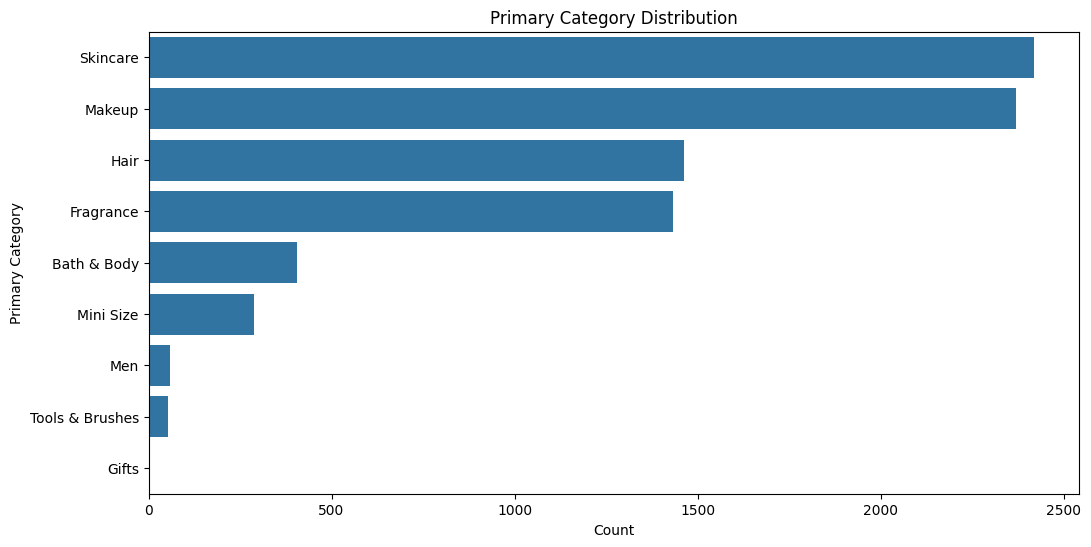

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(y='primary_category',data=df_product,order=df_product['primary_category'].value_counts().index)
plt.title('Primary Category Distribution')
plt.xlabel('Count')
plt.ylabel('Primary Category')
plt.show()


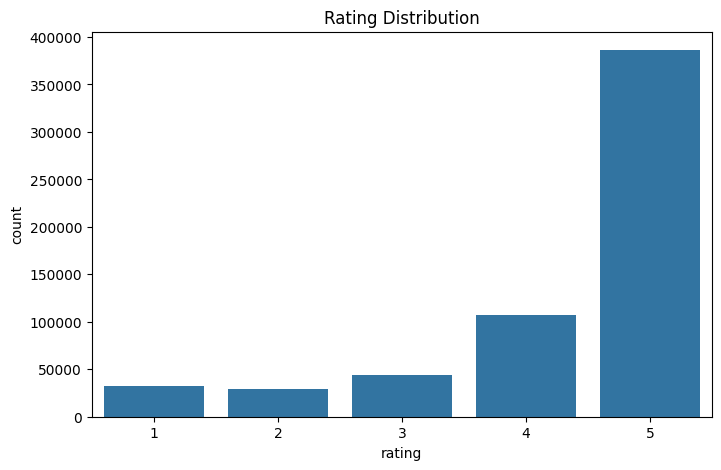

In [ ]:
#product data insights
plt.figure(figsize=(8,5))
sns.countplot(x='rating',data=df_review)
plt.title('Rating Distribution')
plt.show()

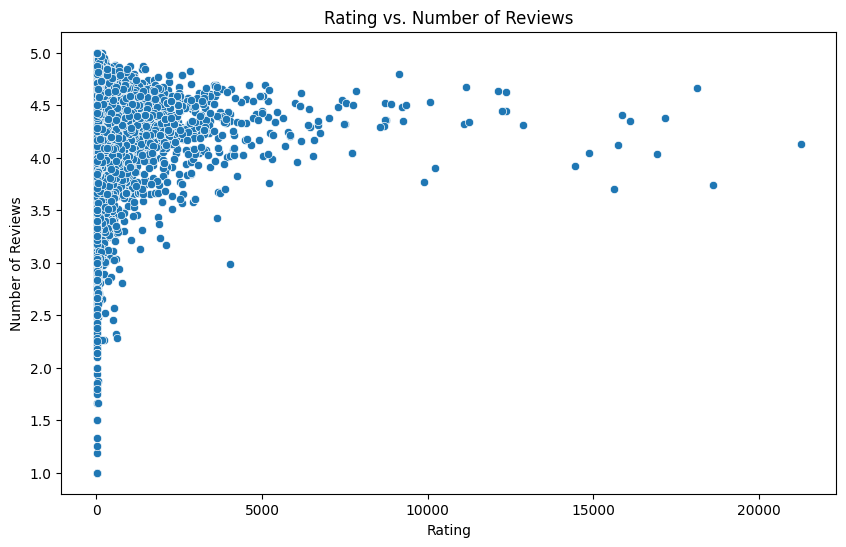

In [ ]:
# Scatter plot of rating vs. number of reviews per product
plt.figure(figsize=(10, 6))



sns.scatterplot(x='reviews', y='rating', data=df_product)
plt.title('Rating vs. Number of Reviews')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()



Content-Based Filtering

Implementing of content-based filterimg

1. TF-IDF for product names
2. BERT for product description/highlights




In [ ]:
#TF-IDF for prodcut names
tfidf=TfidfVectorizer()
product_name_vectors=tfidf.fit_transform(df_product['product_name'])
ingredient_vector=tfidf.fit_transform(df_product['ingredients'])
prim_category_vector=tfidf.fit_transform(df_product['primary_category'])
tert_category_vecotr=tfidf.fit_transform(df_product['tertiary_category'])

In [ ]:
#combine ingredient and category vectors
from scipy.sparse import hstack
feature_vectors=hstack([product_name_vectors,ingredient_vector,prim_category_vector,tert_category_vecotr])


In [ ]:
#compute cosine similarity on the combined feature vectors
similarity_matrix_tfidf_comnined=cosine_similarity(feature_vectors)



BERT for product descriptions/highlights

In [ ]:
from sentence_transformers import SentenceTransformer
#load Sentence - Bert Model
model=SentenceTransformer('all-MiniLM-L6-v2')

#List of columns for product description including 'highlights'
columns_to_combine=['highlights']

#create a "description" column by combining relevant columns
df_product['description']=df_product[columns_to_combine].apply(lambda row:' '.join(row.values.astype(str)),axis=1)

#Generate Embeddings
product_embeddings=model.encode(df_product['description'],convert_to_tensor=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:

# Move the tensor to the CPU and convert it to a NumPy array
product_embeddings_np = product_embeddings.cpu().numpy()

#cosine similarity for BERT-based embeddings
similarity_matrix_bert=cosine_similarity(product_embeddings_np)

Chembert for ingrdients

In [ ]:
!pip install pubchempy

  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13819 sha256=b99878c8b44eb01dc1ec811314b16ba745eee8fd31b180ef83ed029dd6a561ea
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy


In [ ]:
import pubchempy as pcp
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from concurrent.futures import ThreadPoolExecutor, as_completed


In [ ]:
# Initialize CHEMBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1").to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

In [ ]:

# Load your dataset and ensure 'ingredients' is preprocessed
df_product = pd.read_csv('/content/product_info.csv')
df_product = df_product[["product_name", "ingredients"]]


In [ ]:
 #Cache SMILES Structures
 # Dictionary to cache SMILES structures for each unique chemical
smiles_cache = {}

def get_smiles(chemical_name):
    """Retrieve SMILES from PubChem with caching to avoid duplicate calls."""
    if chemical_name in smiles_cache:
        return smiles_cache[chemical_name]
    try:
        compound = pcp.get_compounds(chemical_name, 'name')[0]
        smiles = compound.isomeric_smiles
    except:
        smiles = None
    smiles_cache[chemical_name] = smiles  # Cache the result
    return smiles


In [ ]:
# Generate Batched CHEMBERT Embeddings
def encode_smiles_batch(smiles_list):
    """Tokenize and embed a batch of SMILES strings using CHEMBERT."""
    tokens = tokenizer(smiles_list, padding=True, truncation=True, return_tensors="pt").to(model.device)
    with torch.no_grad():
        embeddings = model(**tokens).last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy()

def get_product_embedding(ingredients):
    """Generate a mean embedding for a product's ingredients using cached SMILES."""
    smiles_list = [get_smiles(chemical.strip()) for chemical in str(ingredients).split(",")]
    smiles_list = [smiles for smiles in smiles_list if smiles]  # Remove None values
    if not smiles_list:
        return np.zeros(model.config.hidden_size)  # Return zero vector if no valid SMILES

    # Batch processing for efficiency
    embeddings = []
    batch_size = 8  # Adjust based on memory capacity
    for i in range(0, len(smiles_list), batch_size):
        batch_smiles = smiles_list[i:i + batch_size]
        embeddings.append(encode_smiles_batch(batch_smiles))
    embeddings = np.vstack(embeddings)

    # Return the mean embedding for the product
    return embeddings.mean(axis=0)


In [ ]:
#Parallel Processing for Products
# Use ThreadPoolExecutor for parallel processing of products
all_embeddings = []

with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers based on CPU cores
    futures = {executor.submit(get_product_embedding, ingredients): idx for idx, ingredients in enumerate(df_product['ingredients'])}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Generating product embeddings"):
        all_embeddings.append(future.result())



Generating product embeddings:   0%|          | 0/8494 [00:00<?, ?it/s]

In [ ]:
# Convert list of embeddings into a numpy array
ingredient_embeddings = np.vstack(all_embeddings)


In [ ]:
#Compute Cosine Similarity
similarity_matrix_chem = cosine_similarity(ingredient_embeddings)

In [ ]:
# Combine TF-IDF, BERT, and ChemBERT similarities with equal weights
final_similarity_matrix = (0.33 * similarity_matrix_tfidf_comnined +
                           0.33 * similarity_matrix_bert +
                           0.34 * similarity_matrix_chem)

In [ ]:
# Combine TF-IDF, BERT, and ChemBERT similarities with equal weights
final_similarity_matrix = (
    0.33 * similarity_matrix_tfidf_comnined +
    0.33 * similarity_matrix_bert +
    0.34 * similarity_matrix_chem
)

# Function to get top N recommendations for a given product index
def get_top_recommendations(similarity_matrix, product_index, top_n=10):
    """
    Given a similarity matrix, return the top N product recommendations for a product.
    Args:
        similarity_matrix (numpy.ndarray): The final similarity matrix.
        product_index (int): Index of the product for which recommendations are to be generated.
        top_n (int): Number of recommendations to retrieve.
    Returns:
        List of tuples containing product index and similarity score.
    """
    # Exclude the product itself (diagonal entry) and sort by similarity score
    scores = list(enumerate(similarity_matrix[product_index]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    top_recommendations = scores[1:top_n + 1]  # Skip the first entry (self-similarity)
    return top_recommendations

# Generate top recommendations for all products
def generate_recommendations(df_product, similarity_matrix, top_n=10):
    """
    Generate top N recommendations for each product.
    Args:
        df_product (pandas.DataFrame): DataFrame containing product information.
        similarity_matrix (numpy.ndarray): The final similarity matrix.
        top_n (int): Number of recommendations to generate for each product.
    Returns:
        recommendations (dict): Dictionary where keys are product names and values are lists of recommended product names.
    """
    recommendations = {}
    for idx, product_name in enumerate(df_product['product_name']):
        top_recommendations = get_top_recommendations(similarity_matrix, idx, top_n)
        recommended_products = [
            (df_product.iloc[rec_idx]['product_name'], score) for rec_idx, score in top_recommendations
        ]
        recommendations[product_name] = recommended_products
    return recommendations

# Generate recommendations
top_n = 10
recommendations = generate_recommendations(df_product, final_similarity_matrix, top_n)

# Display recommendations for the first product as an example
product_name = df_product['product_name'][0]
print(f"Top {top_n} recommendations for '{product_name}':")
for rec_product, score in recommendations[product_name]:
    print(f"{rec_product} (Similarity: {score:.4f})")



Top 10 recommendations for 'Fragrance Discovery Set':
Wake the F*ck Up Everyday Essentials Set (Similarity: 0.8215)
Mini Perfume Oil Discovery Sampler Set (Similarity: 0.8137)
No. 04 Bois de Balincourt Luxury Perfume Gift Set (Similarity: 0.8134)
Fully Booked Rollerball Perfume Gift set (Similarity: 0.8065)
Angie Perfume (Similarity: 0.8039)
Madie Perfume (Similarity: 0.8035)
Dylan Perfume Oil (Similarity: 0.7946)
Orange Blossom Eau de Parfum (Similarity: 0.7888)
Sunkissed Hibiscus Fine Fragrance Set (Similarity: 0.7880)
Crescent Beach Perfume (Similarity: 0.7821)


Collabrative Filtering

Implementing three collabrative filtering algorithms: SVD,KNn and NMF with pearson correlation

In [ ]:
# Create a Surprise Dataset
reader = Reader(rating_scale=(0, 5))
surprise_data = Dataset.load_from_df(df_review, reader)










In [ ]:
# Split the data into training and testing sets
# Import necessary libraries
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(surprise_data, test_size=.2, random_state=42)

In [ ]:
# Use SVD algorithm
model_svd = SVD()

In [ ]:

# Perform cross-validation on surprise data (train-test)
cv_results = cross_validate(model_svd, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0151  1.0124  1.0136  1.0175  1.0190  1.0155  0.0024  
MAE (testset)     0.7493  0.7470  0.7481  0.7505  0.7499  0.7490  0.0013  
Fit time          8.92    9.07    9.81    10.26   10.25   9.66    0.57    
Test time         0.83    1.45    1.51    1.43    0.65    1.17    0.36    


In [ ]:
# Display the average RMSE and MAE scores of SVD
print("Cross-validation Results (SVD):")
print(f"RMSE: {cv_results['test_rmse'].mean()}")
print(f"MAE: {cv_results['test_mae'].mean()}")

Cross-validation Results (SVD):
RMSE: 1.015527652506672
MAE: 0.748961649623411


In [ ]:
# Train the model on the whole train dataset
trainset = surprise_data.build_full_trainset()
model_svd.fit(trainset)

In [ ]:
# Make predictions for the test set
predictions = model_svd.test(testset)

# Convert Surprise Prediction objects to a format suitable for sklearn evaluation metrics
true_labels = np.array([pred.r_ui for pred in predictions])
predicted_labels = np.array([pred.est for pred in predictions])

# Binarize the true labels and predicted labels (e.g., using a threshold)
threshold = 3
binarized_true_labels = (true_labels >= threshold).astype(int)
binarized_predicted_labels = (predicted_labels >= threshold).astype(int)

# Compute precision, recall, and F1-score
precision = precision_score(binarized_true_labels, binarized_predicted_labels)
recall = recall_score(binarized_true_labels, binarized_predicted_labels)
f1 = f1_score(binarized_true_labels, binarized_predicted_labels)

# Use accuracy.rmse and accuracy.mae instead of the overwritten variables
from surprise import accuracy
rmse_score = accuracy.rmse(predictions)
mae_score = accuracy.mae(predictions)

# Display the evaluation metrics
print("Evaluation Metrics of SVD:")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

RMSE: 0.5315
MAE:  0.3523
Evaluation Metrics of SVD:
Precision: 0.9704474581187903
Recall: 0.9975213850425837
F1-score: 0.9837981895878326


In [ ]:
# Example usage: Get top-N recommendations for a user
user_id = testset[10][0]
#user_id = df_review['author_id'].sample(10000).iloc[0]
n = 10  # Number of recommendations

# Get a list of all unique product IDs
all_product_ids = df_review['product_id'].unique()

# Remove products that the user has already rated
products_rated_by_user = df_review[df_review['author_id'] == user_id]['product_id'].values
products_to_predict = np.setdiff1d(all_product_ids, products_rated_by_user)

# Make predictions for the products to predict
# Use model_svd instead of best_model
predictions = [model_svd.predict(user_id, product_id) for product_id in products_to_predict]

# Sort the predictions by estimated ratings (in descending order)
predictions.sort(key=lambda x: x.est, reverse=True)



In [ ]:
!pip install tabulate

# List products with high ratings by the sample user
sample_user_ratings = df_review[(df_review['author_id'] == user_id) & (df_review['rating'] >= 4.0)]
sample_user_products = product_info[product_info['product_id'].isin(sample_user_ratings['product_id'])]

print(f"\nProducts with High Ratings by User", user_id, ":")

# Create a list to store the product details
product_details = []

# Populate the product_details list
for idx, product in sample_user_products.iterrows():
    product_id = product['product_id']
    product_name = product['product_name']
    primary_category = product['primary_category']
    rating = sample_user_ratings[sample_user_ratings['product_id'] == product_id]['rating'].values[0]
    product_details.append([product_id, product_name, primary_category, rating])

# Import the tabulate function
from tabulate import tabulate
# Display the product details as a table
headers = ["Product ID", "Product Name", "Primary Category", "Rating"]
print(tabulate(product_details, headers=headers, tablefmt="psql"))

# Get the top-N recommended products
top_n_recommendations = [prediction.iid for prediction in predictions[:n]]

# Populate the recommendations list
recommendations = []
for i, prediction in enumerate(predictions[:n], start=1):
    product_id = prediction.iid

    # Find the product details in df_product
    product_details = product_info[product_info['product_id'] == product_id]

    if len(product_details) > 0:
        product_name = product_details['product_name'].values[0]
        primary_category = product_details['primary_category'].values[0]

        # Append the recommendation to the list
        recommendations.append([i, product_id, product_name, primary_category])

# Display the top-N recommendations as a table
headers = ["Rank", "Product ID", "Product Name", "Primary Category"]
print(f"\nTop-{n} Recommendations for User {user_id}:")
print(tabulate(recommendations, headers=headers, tablefmt="psql"))


Products with High Ratings by User 21135067314 :
+--------------+-------------------------------------+--------------------+----------+
| Product ID   | Product Name                        | Primary Category   |   Rating |
|--------------+-------------------------------------+--------------------+----------|
| P480612      | Santorini Grape Poreless Skin Cream | Skincare           |        4 |
+--------------+-------------------------------------+--------------------+----------+

Top-10 Recommendations for User 21135067314:
+--------+--------------+------------------------------------------------------------------+--------------------+
|   Rank | Product ID   | Product Name                                                     | Primary Category   |
|--------+--------------+------------------------------------------------------------------+--------------------|
|      1 | P417238      | Green Clean Makeup Removing Cleansing Balm                       | Skincare           |
|      2 | P4

kNN Basic(user-based  collabrative filtering with pearson Correlation)

In [ ]:
# Assuming you have your data in a pandas DataFrame 'df_review' with columns 'author_id', 'product_id', and 'rating'
reader = Reader(rating_scale=(df_review['rating'].min(), df_review['rating'].max()))
surprise_data = Dataset.load_from_df(df_review[['author_id', 'product_id', 'rating']], reader)




In [ ]:
# Feature Scaling (Important for KNN)
from sklearn.preprocessing import StandardScaler  # For feature scaling
#df_product and contains relevant product features

# Assuming 'product' Series contains 'product_id' and you want to merge it with df_product:
if 'product_id' not in df_product.columns:  # Check if column already exists
    # Try to extract product_ids from 'product' series and assign to df_product
    if 'product_id' in product.index: # Check if the 'product' Series has an index named 'product_id'
        # Assign the value directly (without using .values)
        df_product['product_id'] = product.loc['product_id']
    else:
        #If 'product' Series doesn't have an index named 'product_id', assume it's a column and contains product_ids.
        df_product = pd.merge(df_product, product[['product_id']], left_index=True, right_index=True, how='left') # Merge to add product_id column

In [ ]:
# One-hot encoding for categorical features in product info
# Assuming df_product contains the features for one-hot encoding
# Replace 'product_name', 'primary_category' with your actual feature columns
feature_columns = ['product_name', 'primary_category']

# Check if 'primary_category' is in df_product, if not, add it
if 'primary_category' not in df_product.columns:
    # Assuming 'product' is a Series or DataFrame containing 'primary_category':
    # If 'product' is a Series:
    if isinstance(product, pd.Series) and 'primary_category' in product.index:
        df_product['primary_category'] = product['primary_category']
    # If 'product' is a DataFrame:
    elif isinstance(product, pd.DataFrame) and 'primary_category' in product.columns:
        # Merge based on a common column if necessary (e.g., 'product_id')
        df_product = pd.merge(df_product, product[['product_id', 'primary_category']], on='product_id', how='left')
    else:
        raise KeyError("Could not find 'primary_category' in 'product' Series or DataFrame.")

# Proceed with one-hot encoding
df_features = df_product[feature_columns]
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df_features)
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(feature_columns))
# You might want to merge encoded_df back to df_product:
# df_product = pd.concat([df_product, encoded_df], axis=1)

In [ ]:
# Concatenate encoded features back to product_info DataFrame (optional, for other uses)
df_product_encoded = pd.concat([product_info, encoded_df], axis=1)

# Split data into train and test sets
trainset, testset = train_test_split(surprise_data, test_size=0.20)

# Create and train the KNN model (item-based collaborative filtering)
sim_options = {'name': 'cosine', 'user_based': False}  # user_based=False for item-based filtering
model_knn = KNNBasic(sim_options=sim_options)
model_knn.fit(trainset)

# Make predictions on the test set
predictions = model_knn.test(testset)

# Calculate RMSE and MAE
from surprise import accuracy
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

# Convert Surprise Prediction objects to a format suitable for sklearn evaluation metrics
true_labels = np.array([pred.r_ui for pred in predictions])
predicted_labels = np.array([pred.est for pred in predictions])

# Binarize the true labels and predicted labels (e.g., using a threshold)
threshold = 3  # You can adjust this threshold
binarized_true_labels = (true_labels >= threshold).astype(int)
binarized_predicted_labels = (predicted_labels >= threshold).astype(int)

# Calculate precision, recall, and F1-Score using sklearn
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(binarized_true_labels, binarized_predicted_labels)
recall = recall_score(binarized_true_labels, binarized_predicted_labels)
f1 = f1_score(binarized_true_labels, binarized_predicted_labels)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0747
MAE:  0.6989


In [ ]:
# Display the evaluation metrics
print("Evaluation Metrics of K-NN:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Evaluation Metrics of K-NN:
RMSE: 1.0746570010020284
MAE: 0.6988525305493789
Precision: 0.919628298413255
Recall: 0.9776696676545695
F1-Score: 0.9477611940298507


NMF

In [ ]:
# NMF-non-negative matric factorization

# Assume 'author_id', 'product_id', 'rating' columns exist in reviews_df
# Create user-item matrix using pivot_table to handle duplicates
user_item_matrix = df_review.pivot_table(index='author_id',
                                       columns='product_id',
                                       values='rating',
                                       aggfunc='mean'  # or another aggregation function like 'first', 'last' etc.
                                       ).fillna(0)

# Ensure matrix values are non-negative
user_item_matrix = np.maximum(user_item_matrix, 0)

# Create a Reader object
reader = Reader(rating_scale=(df_review['rating'].min(), df_review['rating'].max()))

# Load the DataFrame into a Dataset object
data = Dataset.load_from_df(df_review[['author_id', 'product_id', 'rating']], reader)

# Now you can use train_test_split from surprise
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Define NMF model with chosen number of factors (latent features)
from surprise.prediction_algorithms.matrix_factorization import NMF  # make sure to import correct NMF

n_factors = 45
nmf_model = NMF(n_factors=n_factors)

# Fit the model to the training data
nmf_model.fit(trainset)  # Use fit method of surprise NMF

# Access user and item factors after fitting
user_features = nmf_model.pu
item_features = nmf_model.qi

In [ ]:
# Make predictions on the test set
from surprise import accuracy
predictions = nmf_model.test(testset)

In [ ]:

# Convert Surprise Prediction objects to a format suitable for sklearn evaluation metrics
true_labels = np.array([pred.r_ui for pred in predictions])
predicted_labels = np.array([pred.est for pred in predictions])

# Binarize the true labels and predicted labels (e.g., using a threshold)
threshold = 3  # You can adjust this threshold
binarized_true_labels = (true_labels >= threshold).astype(int)
binarized_predicted_labels = (predicted_labels >= threshold).astype(int)

# Calculate precision, recall, and F1-score using sklearn
precision = precision_score(binarized_true_labels, binarized_predicted_labels)
recall = recall_score(binarized_true_labels, binarized_predicted_labels)
f1 = f1_score(binarized_true_labels, binarized_predicted_labels)

# Display the evaluation metrics
print("Evaluation Metrics of NMF:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Evaluation Metrics of NMF:
RMSE: 1.0746570010020284
MAE: 0.6988525305493789
Precision: 0.9187584180237541
Recall: 0.9788572280512123
F1-score: 0.9478561374381925


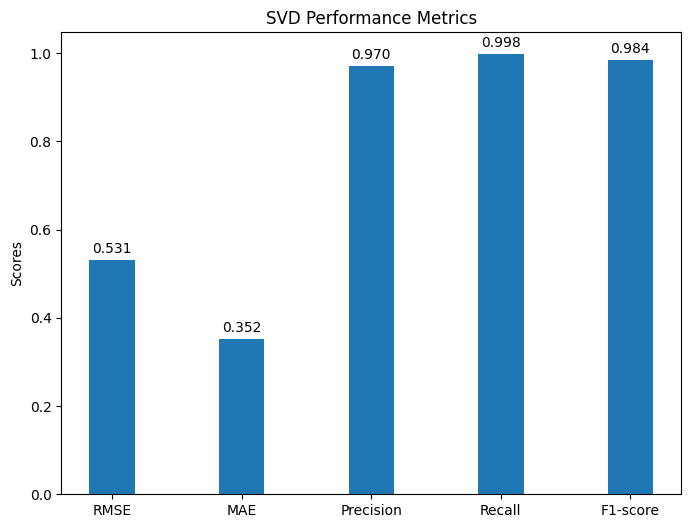

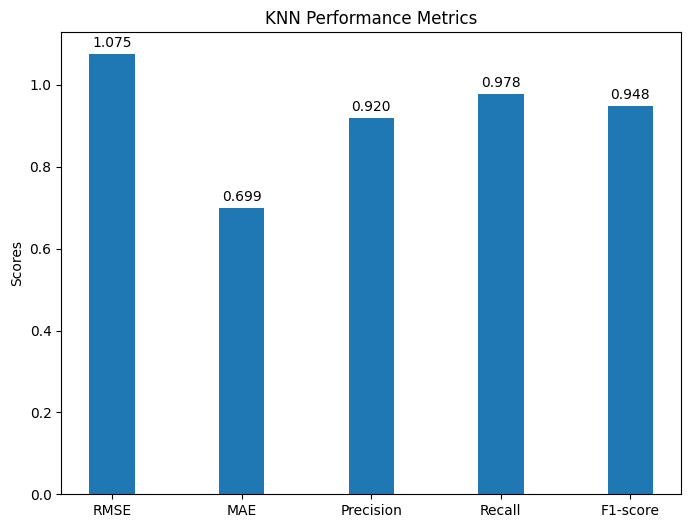

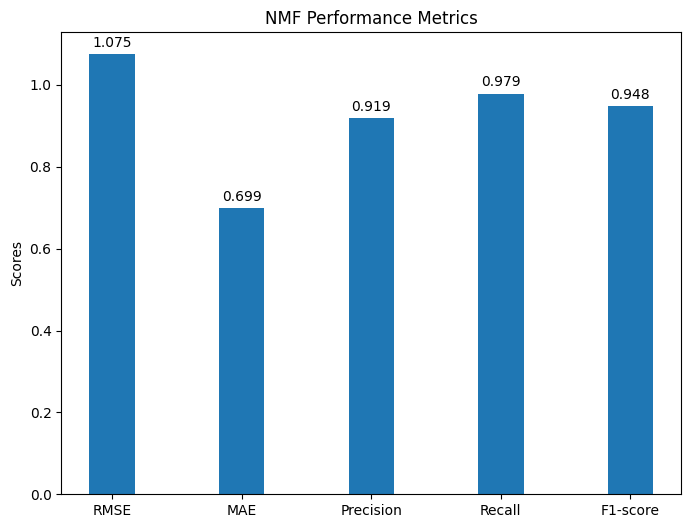

In [ ]:
# Define the metrics and model names
metrics = ['RMSE', 'MAE', 'Precision', 'Recall', 'F1-score']
model_names = ['SVD', 'KNN', 'NMF']

# Define the metric values for each model
svd_values = [0.5315, 0.3523, 0.9704474581187903, 0.9975213850425837, 0.9837981895878326]

knn_values = [1.0746570010020284, 0.6988525305493789, 0.919628298413255,
              0.9776696676545695, 0.9477611940298507]

nmf_values = [1.0746570010020284, 0.6988525305493789, 0.9187584180237541,
              0.9788572280512123, 0.9478561374381925]

# Combine the values into a list
values = [svd_values, knn_values, nmf_values]

# Create separate charts for each model
import matplotlib.pyplot as plt
import numpy as np

for i, model_name in enumerate(model_names):
    fig, ax = plt.subplots(figsize=(8, 6))

    x = np.arange(len(metrics))  # the label locations
    width = 0.35  # the width of the bars

    rects = ax.bar(x, values[i], width, label=model_name)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title(f'{model_name} Performance Metrics')
    ax.set_xticks(x, metrics)  # Set x-axis ticks to metric names

    # Add value labels on top of the bars
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(rect.get_x() + rect.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom')

    plt.show()